In [21]:
import sys
sys.path.append("../")

In [2]:
import os 
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import glob
import importlib
import random
from SRCNN import main
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
import math

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.compat.v1 import Session
from tensorflow.compat.v1 import get_default_graph

from EDSR import data_generator as data_generator
from EDSR import utils as utils
from EDSR import losses as losses
from EDSR import config as config
from EDSR import lr_finder as lr_finder

seed = 2020
os.environ['PYTHONHASHSEED'] = '0'                      
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

session_conf = ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = Session(graph=get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [12]:
importlib.reload(data_generator)

crop_size = 96
img_path = config.DATA_PATH
batch_size = 64
scale = 2
epochs = 30

img_path_list = sorted(glob.glob(os.path.join(img_path, '*.jpg')))
test_size = 0.2
img_path_idx = np.arange(len(img_path_list))
train_img_path, val_img_path, train_img_idx, val_img_idx = train_test_split(img_path_list, img_path_idx, \
                                                                            test_size=test_size, random_state=2020)
print(len(train_img_idx), len(val_img_idx))  
train_gen = data_generator.SRCNNDataGenerator(img_path_list=train_img_path, crop_size=crop_size, 
                                         batch_size=batch_size, scale=scale, shuffle = True, crop = True)

val_gen = data_generator.SRCNNDataGenerator(img_path_list=val_img_path, crop_size=crop_size,
                                         batch_size=batch_size, scale=scale, shuffle = True, crop = True)


5912 1478


(64, 96, 96, 3) (64, 96, 96, 3)


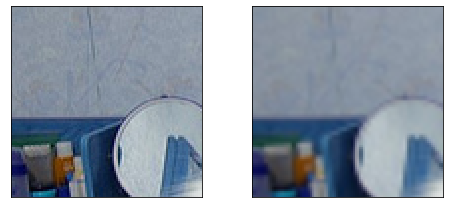

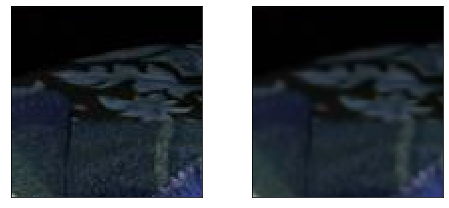

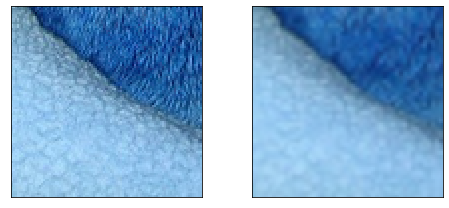

In [14]:
batch_lr_img, batch_hr_img = train_gen[0]
print(batch_lr_img.shape, batch_hr_img.shape)

show_num = 5
for i in range(len(batch_hr_img[:show_num])):
#     utils.show_batch_imgs(idx=i, demo_ori_img=batch_hr_img[:,:,:,0][:show_num], demo_lr_img=batch_lr_img[:,:,:,0][:show_num])
    utils.show_batch_imgs(idx=i, demo_ori_img=batch_hr_img[:show_num], demo_lr_img=batch_lr_img[:show_num])


In [15]:
def model():
    SRCNN = Sequential()
    
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True, input_shape=(None, None, 3)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=3, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='same', use_bias=True))
    
    return SRCNN

In [16]:
srcnn_model = model()
# define optimizer
adam = Adam(lr=0.001)
# compile model
srcnn_model.compile(optimizer=adam, loss='mean_squared_error',  metrics=[losses.PSNR])

srcnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, None, None, 128)   31232     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 3)     4803      
Total params: 109,827
Trainable params: 109,827
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 93 steps
Epoch 1/3
93/93 [==============================] - 22s 239ms/step - loss: 0.2029 - PSNR: 7.4257
Epoch 2/3
65/93 [===================>..........] - ETA: 6s - loss: 0.0126 - PSNR: 19.7910

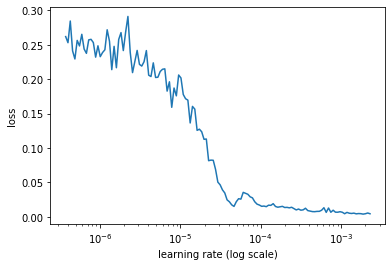

In [18]:

lr_finder = lr_finder.LRFinder(srcnn_model)
lr_finder.find_generator(generator=train_gen, start_lr=1e-07, end_lr=10, epochs=3)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)


In [19]:

checkpoint = ModelCheckpoint("SRCNN_datagen.h5", monitor='val_PSNR', save_best_only=True,
                                 save_weights_only=False, mode='max')
callbacks_list = [checkpoint]

srcnn_model.fit(train_gen, validation_data=val_gen, callbacks=callbacks_list, epochs=epochs)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 93 steps, validate for 24 steps
Epoch 1/30
93/93 [==============================] - 27s 292ms/step - loss: 0.0178 - PSNR: 20.2004 - val_loss: 0.0036 - val_PSNR: 24.4266
Epoch 2/30
93/93 [==============================] - 27s 291ms/step - loss: 0.0029 - PSNR: 25.4347 - val_loss: 0.0026 - val_PSNR: 25.9324
Epoch 3/30
93/93 [==============================] - 27s 289ms/step - loss: 0.0025 - PSNR: 26.1685 - val_loss: 0.0022 - val_PSNR: 26.5591
Epoch 4/30
93/93 [==============================] - 27s 289ms/step - loss: 0.0023 - PSNR: 26.5037 - val_loss: 0.0022 - val_PSNR: 26.7429
Epoch 5/30
93/93 [==============================] - 27s 289ms/step - loss: 0.0021 - PSNR: 26.7444 - val_loss: 0.0020 - val_PSNR: 26.9871
Epoch 6/30
93/93 [==============================] - 27s 289ms/step - loss: 0.0021 - PSNR: 26.9326 - val_loss: 0.0020 - val_PSNR: 27.1077
Epoch 7/30
93/93 [==============================] - 27s 288ms/step - loss: 0.0020 - PS

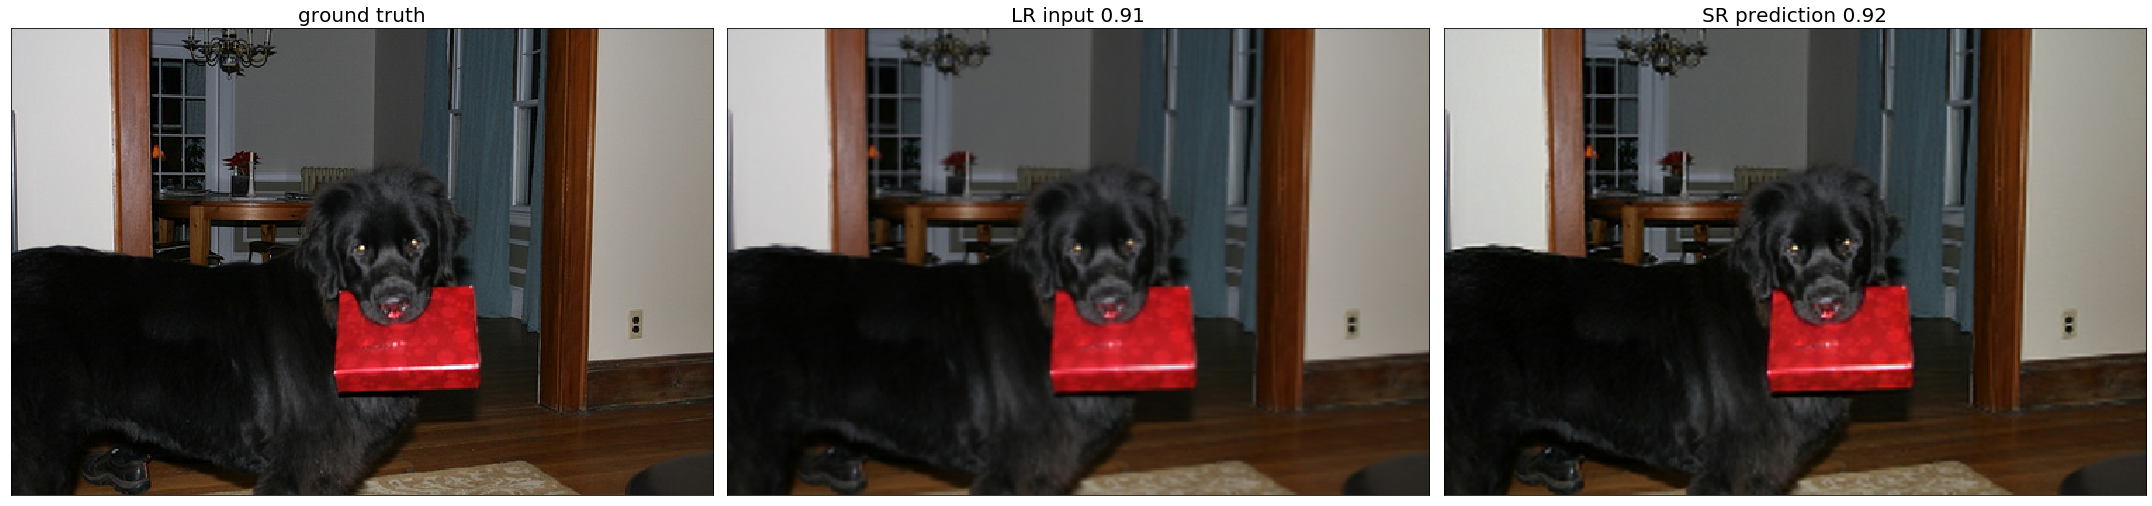

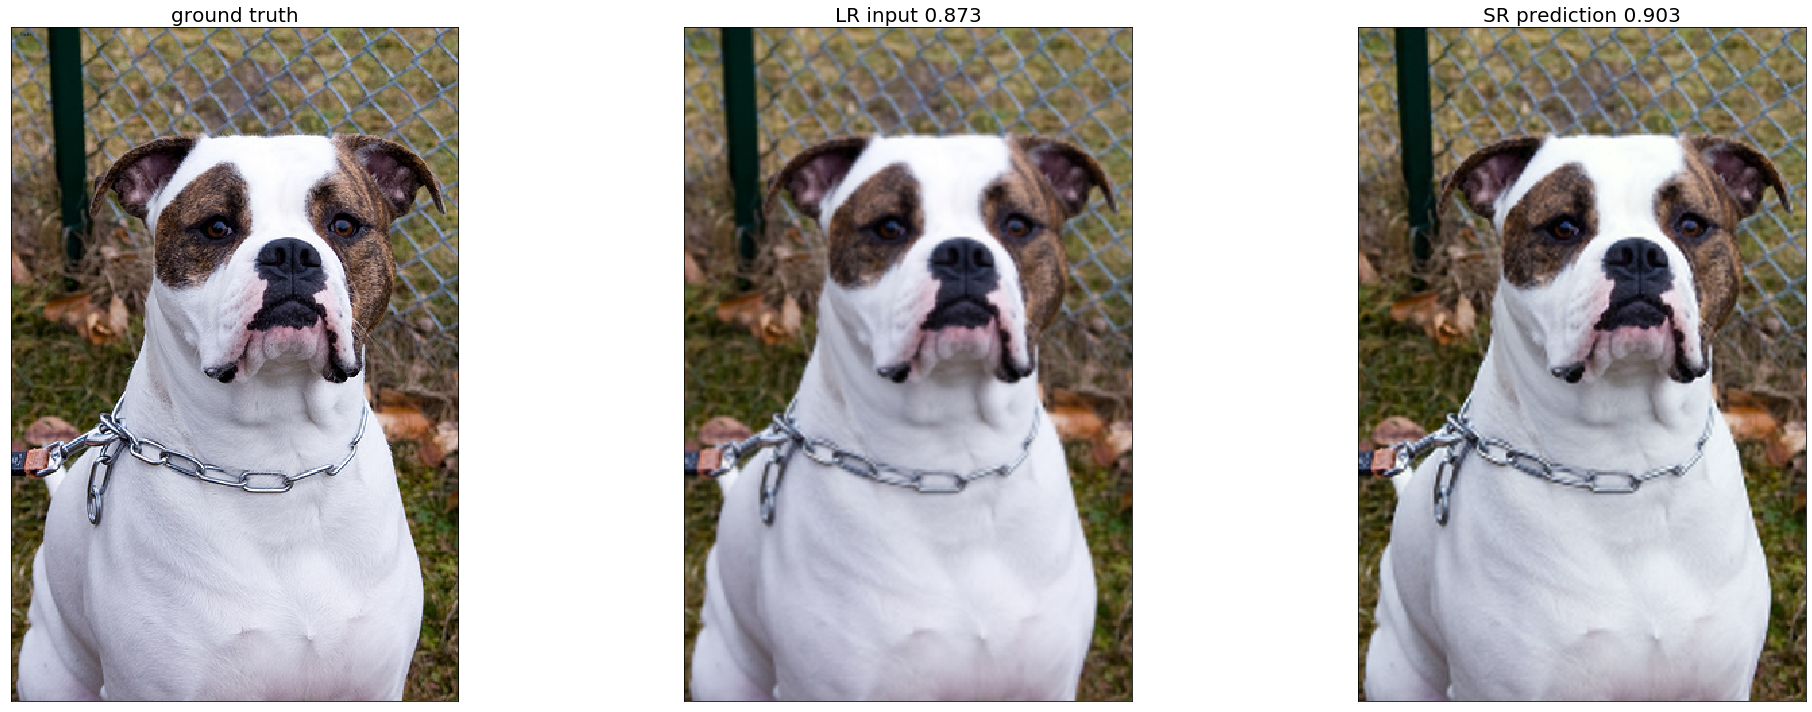

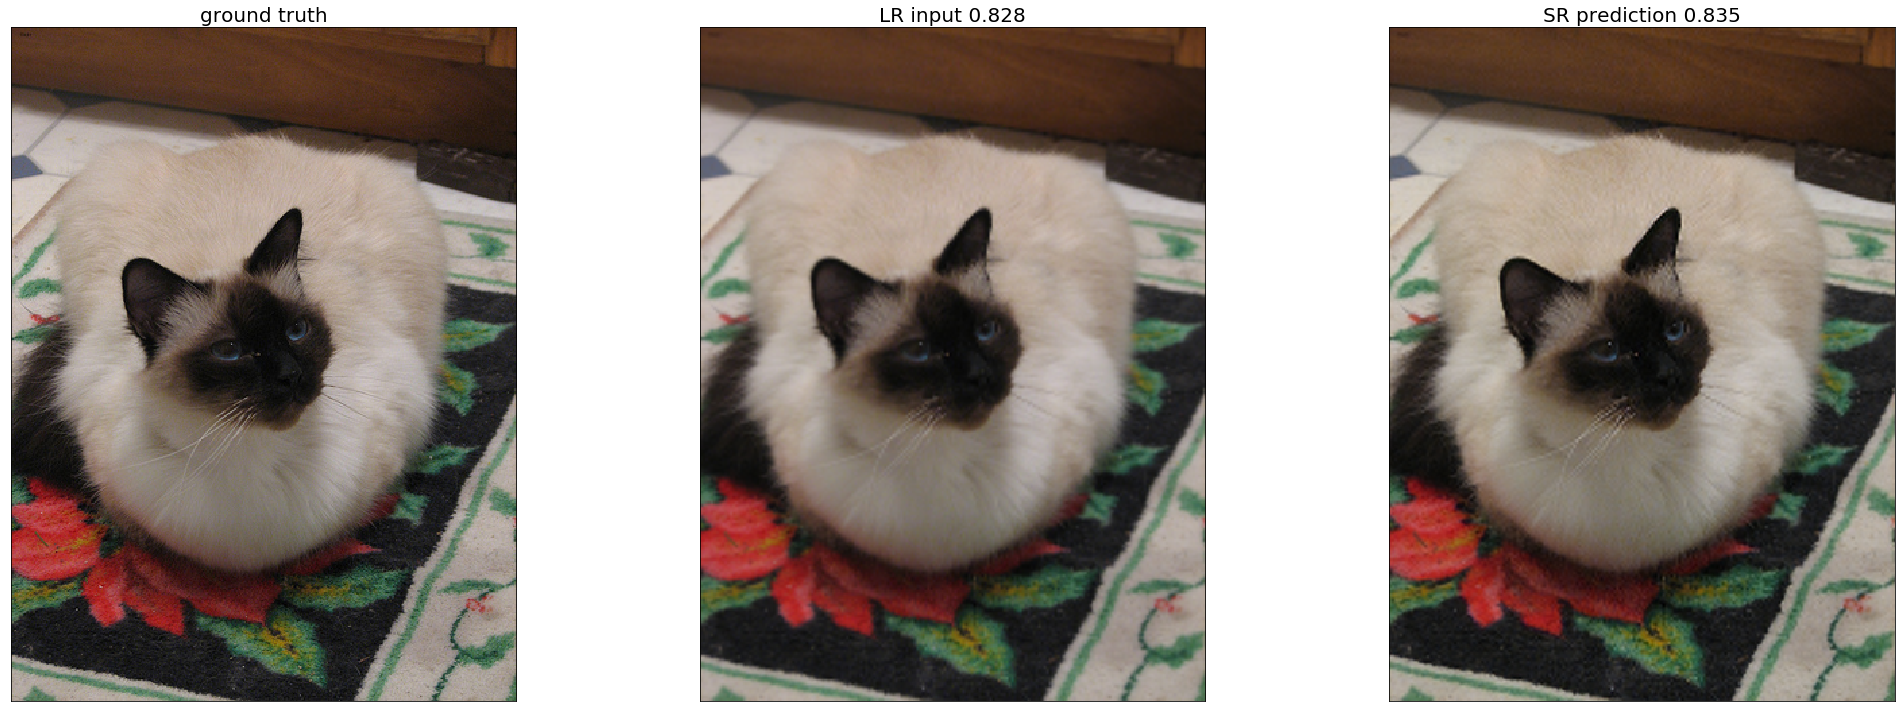

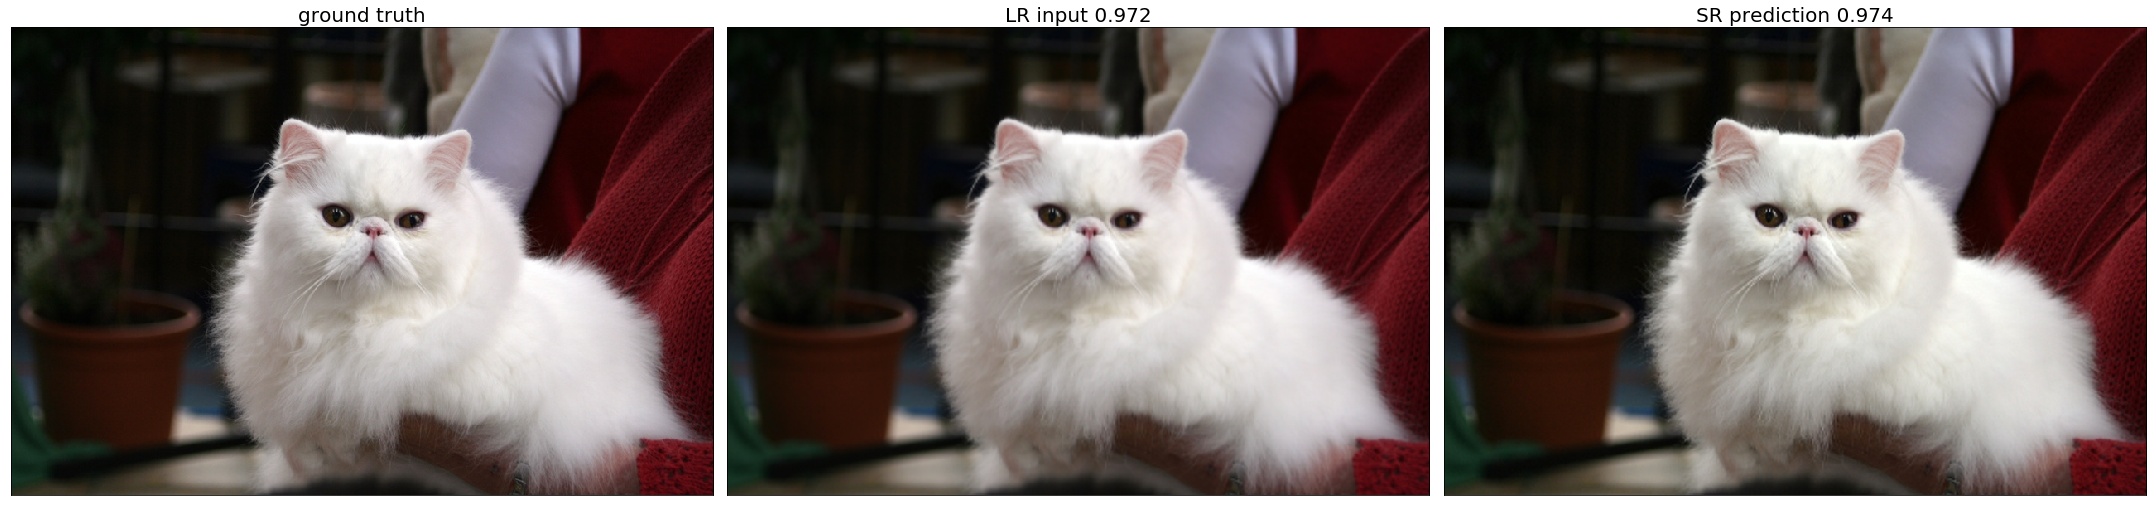

In [24]:
importlib.reload(utils)

srcnn_model = model()
srcnn_model.load_weights("SRCNN_datagen.h5")
utils.predict_and_show(val_img_path[:5], srcnn_model, 2, SRCNN=True)
